<h1>
Final Project Group 31
<h/1>

<h3>
Reading the data
<h/3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import lognorm, expon, gamma, weibull_min, kstest, probplot
from typing import List

In [21]:
df = pd.read_csv('archive/loan_sanction_train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


C:\Users\joerg\AppData\Local\Temp\ipykernel_8176\3079389942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


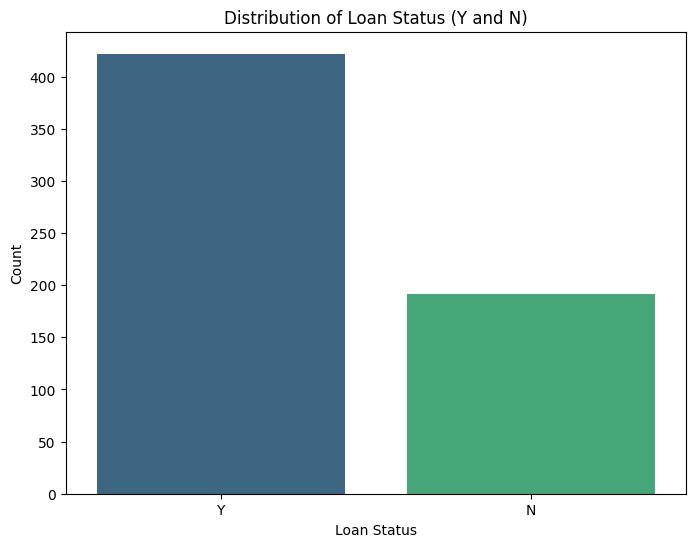

In [3]:
class_counts = df['Loan_Status'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add titles and labels
plt.title("Distribution of Loan Status (Y and N)")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

<h3>
Cleaning the Data
<h/3>

<h4>
Removing NaN values
<h/4>

In [4]:
print(f"Dimensions of the data: {df.shape}")
total_nan = df.isnull().sum().sum()
total_nan_col = df.isnull().sum()
print(f"Number of NaN: {total_nan}", f"\nNumber of NaN per column: \n{total_nan_col}")

Dimensions of the data: (614, 13)
Number of NaN: 149 
Number of NaN per column: 
Loan_ID                0
Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount           22
Loan_Amount_Term      14
Credit_History        50
Property_Area          0
Loan_Status            0
dtype: int64


In [5]:
def plot_nan_distributions(df: pd.DataFrame) -> None:
    """
    Plots the distribution of NaN values in the columns of the dataframe.
    """

    colums_with_nan = df.columns[df.isnull().any()].tolist()

    for col in colums_with_nan:
        plt.figure(figsize=(8, 4))
        df[col].value_counts(dropna=False).plot(kind='bar')
        plt.title(f"Distribution of '{col}' (including NaN values)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


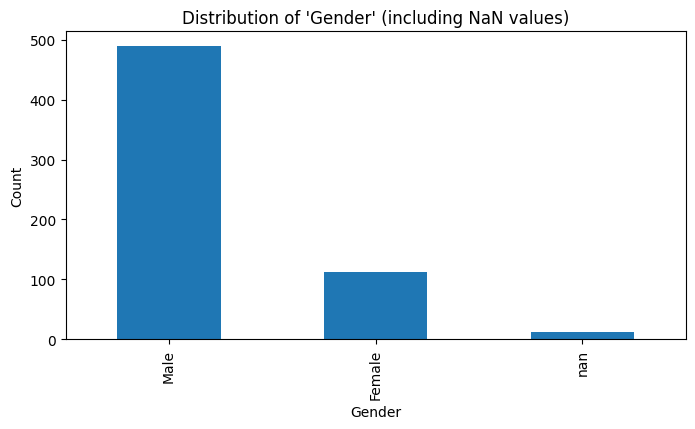

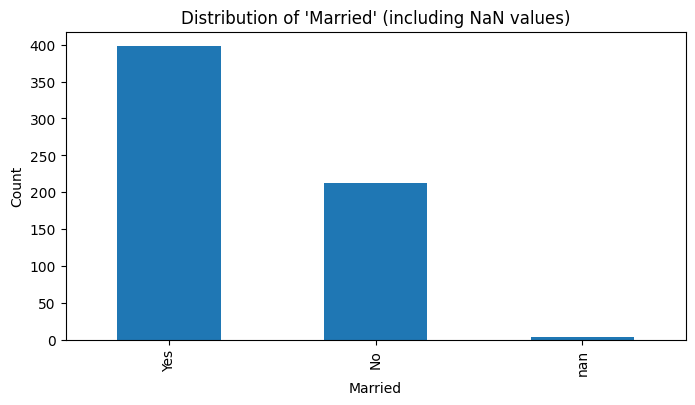

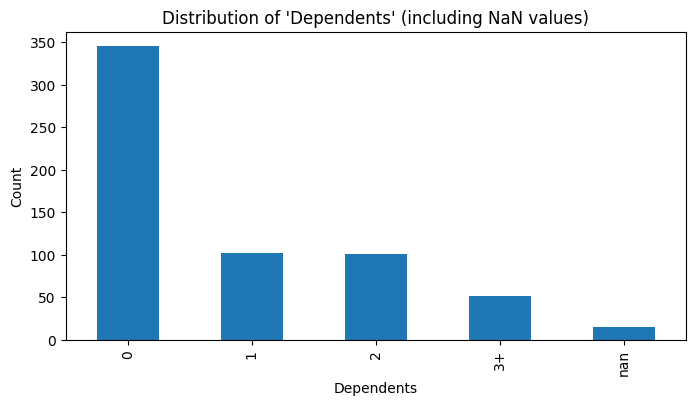

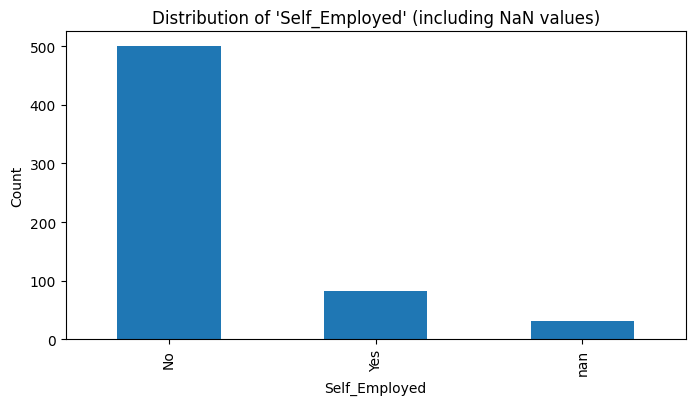

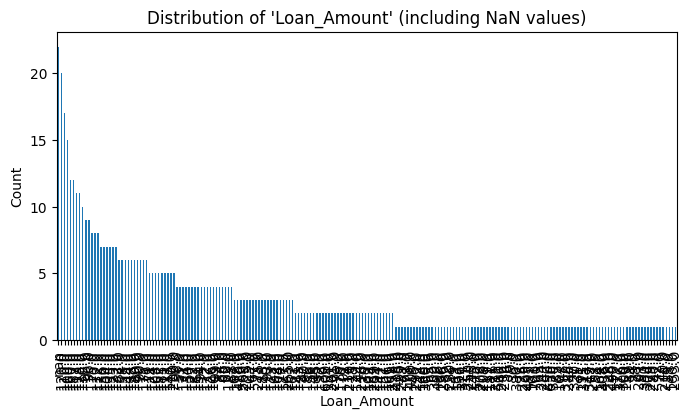

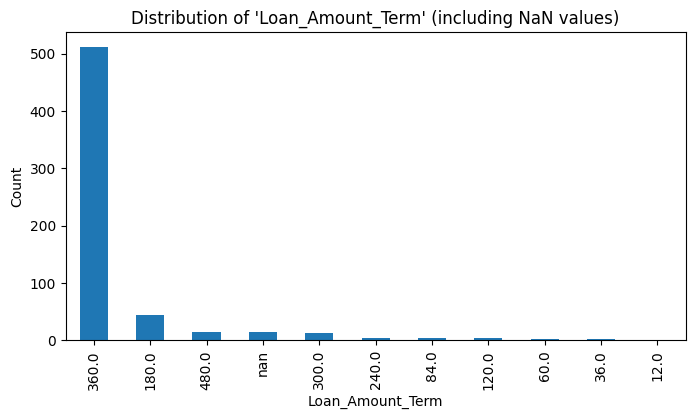

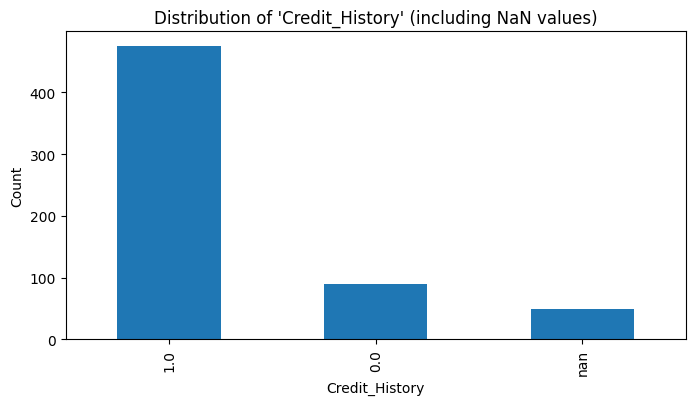

In [6]:
plot_nan_distributions(df)

<h3>
Looking if loan amount is descrete or continous and if so perhaps adda ordinal or catagorical approach
<h/3>

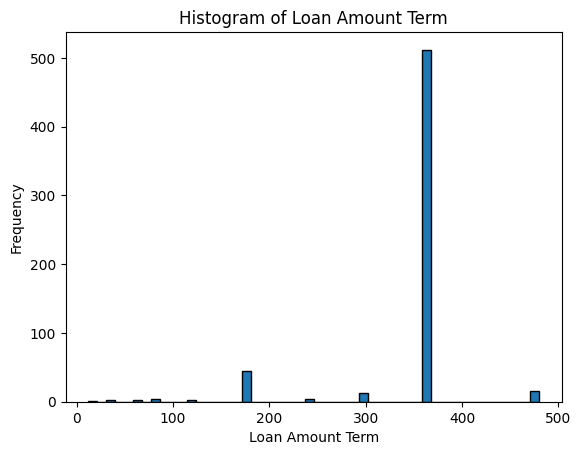

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64


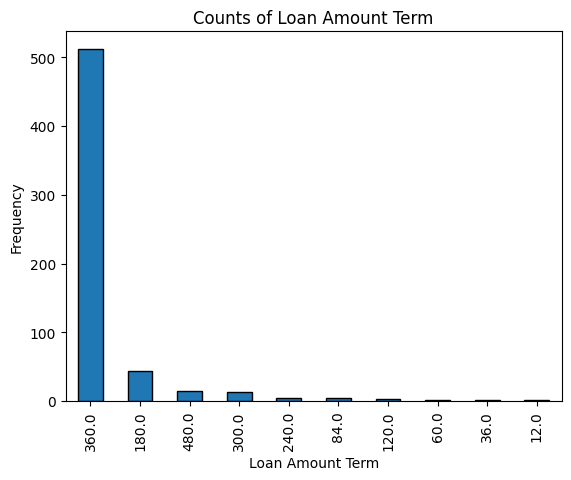

In [7]:
# Plot a histogram with a large number of bins to visualize the distribution
plt.hist(df['Loan_Amount_Term'], bins=50, edgecolor='black')
plt.title('Histogram of Loan Amount Term')
plt.xlabel('Loan Amount Term')
plt.ylabel('Frequency')
plt.show()

# Count the occurrences of each unique value in Loan_Amount_Term
loan_term_counts = df['Loan_Amount_Term'].value_counts()

# Print the counts
print(loan_term_counts)

# Optionally, visualize the counts as a bar plot
loan_term_counts.plot(kind='bar', edgecolor='black')
plt.title('Counts of Loan Amount Term')
plt.xlabel('Loan Amount Term')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Define a function to group Loan_Amount_Term into buckets
def group_loan_term(term):
    if term < 180:
        return 'Short'
    elif term < 360:
        return 'Medium'
    elif term == 360:
        return 'Standard'
    else:  # term > 360
        return 'Long'

# Apply the grouping function to the Loan_Amount_Term column
df['Loan_Amount_Term_Grouped'] = df['Loan_Amount_Term'].apply(group_loan_term)

# Display the grouped categories and their counts
print(df['Loan_Amount_Term_Grouped'].value_counts())

# Optional: One-hot encode the grouped categories for modeling
df = pd.get_dummies(df, columns=['Loan_Amount_Term_Grouped'], prefix='LoanTerm', drop_first=True)


df.head()


Loan_Amount_Term_Grouped
Standard    512
Medium       61
Long         29
Short        12
Name: count, dtype: int64


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,False,False,True
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,False,False,True
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,False,False,True
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,False,False,True
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,False,False,True


<h5>
Rather than dropping all rows containing NaN values—which would remove over 100 rows from our dataset of only 614—it’s more effective to handle these values thoughtfully. Research suggests that even missing values can carry predictive weight. Instead of leaving cells empty, we’ll apply different strategies based on the data type and distribution of each column. For Credit History, where data is missing entirely, we'll set NaN values to 0. For categorical columns, where a dominant class exists, filling NaN values with the mode makes logical sense. For the Loan Amount column, which approximates an exponential distribution, using the average provides a better estimate for missing values.
<h/5>

In [9]:
def clean_data(df: pd.DataFrame, mode: List[str]) -> pd.DataFrame:
    """ 
    Clean the data by filling NaN values with the mean for 'Loan_Amount', 0 to the credit history,  and the mode for the columns in the 'mode' list.
    """

    cleaned_df = df.copy()
    cleaned_df['Credit_History'] = cleaned_df['Credit_History'].fillna(0)
    cleaned_df['Loan_Amount'] = cleaned_df['Loan_Amount'].fillna(cleaned_df['Loan_Amount'].mean())

    for col in mode:
        cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])

    return cleaned_df

In [10]:
colums_2_clean = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']

df = clean_data(df, colums_2_clean)

total_nan = df.isnull().sum().sum()
print(f"Number of NaN: {total_nan}")

df.head(10)

Number of NaN: 0


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,False,False,True
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,False,False,True
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,False,False,True
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,False,False,True
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,False,False,True
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y,False,False,True
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y,False,False,True
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N,False,False,True
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y,False,False,True
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N,False,False,True


<h5>
An interesting case arises here because most co-applicants don't have an income. However, when a co-applicant first does have an income, I believe it is still normally attributed. Therefore, i am adding a column to the data indicating if a co-applicant is working or not, and then i will normalize that data
<h/5>

In [11]:

# Create a new column 'Coapplicant_Working'
df['Coapplicant_Working'] = np.where(df['Coapplicant_Income'] > 0, 1, 0)
df.head() 

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Coapplicant_Working
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,False,False,True,0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,False,False,True,1
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,False,False,True,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,False,False,True,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,False,False,True,0


<h3>
Normalizing Data
<h/3>

<h5>
the "Loan_Amount" seems to be following a exponetial decreasing,  log normal or gamma distribution. Depending on which model fits better we should normalize the data
<h/5>

In [12]:

def best_fit_distribution(df: pd.DataFrame, column:str):
    """
    Finds the best-fitting distribution for a specified column in a cleaned DataFrame.
    
    Parameters:
    df (pd.DataFrame): Cleaned DataFrame containing the data.
    column (str): Name of the column to fit distributions to.

    Returns:
    dict: Dictionary containing the name, KS statistic, p-value, and parameters of the best-fitting distribution.
    """
    # Candidate distributions to test
    distributions = {
        'Log-normal': lognorm,
        'Exponential': expon,
        'Gamma': gamma,
        'Weibull': weibull_min
        
    }

    fit_results = {}

    # Loop over distributions to fit and test
    for name, distribution in distributions.items():
        params = distribution.fit(df[column])
        d_statistic, p_value = kstest(df[column], distribution.name, args=params)
        fit_results[name] = {
            'KS Statistic': d_statistic,
            'p-value': p_value,
            'Parameters': params
        }

    # Find the best distribution based on the highest p-value
    best_fit = max(fit_results.items(), key=lambda x: x[1]['p-value'])
    best_distribution = {
        'Best Distribution': best_fit[0],
        'KS Statistic': best_fit[1]['KS Statistic'],
        'p-value': best_fit[1]['p-value'],
        'Parameters': best_fit[1]['Parameters']
    }

    # print("\nDistribution Fit Results:\n")
    # for dist_name, stats in fit_results.items():
    #     print(f"{dist_name}:")
    #     print(f"  KS Statistic: {stats['KS Statistic']:.4f}")
    #     print(f"  p-value: {stats['p-value']:.4f}")
    #     print(f"  Parameters: {stats['Parameters']}\n")

    # Print the best-fitting distribution in a clear format
    print("\nBest Fitting Distribution:\n")
    print(f"{best_distribution['Best Distribution']}:")
    print(f"  KS Statistic: {best_distribution['KS Statistic']:.4f}")
    print(f"  p-value: {best_distribution['p-value']:.4f}")
    print(f"  Parameters: {best_distribution['Parameters']}\n")


In [13]:
best_fit_distribution(df, 'Loan_Amount')


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0792
  p-value: 0.0008
  Parameters: (0.42475558658593976, -18.001512791270773, 149.36010312325297)



In [14]:
best_fit_distribution(df, 'Applicant_Income')



Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0865
  p-value: 0.0002
  Parameters: (0.6218119518274026, -116.84111751508071, 4335.977983277862)



In [15]:
df_coapplicants = df[df['Coapplicant_Income'] > 0].copy()
best_fit_distribution(df_coapplicants , 'Coapplicant_Income')


Best Fitting Distribution:

Log-normal:
  KS Statistic: 0.0863
  p-value: 0.0117
  Parameters: (0.5799442708281715, -239.07369863909366, 2562.226352544695)



<h5>
Since the data in Loan_Amount is right-skewed, we found that a log-normal transformation provides the best fit. This transformation reduces the skew, making the distribution more symmetric and closer to a normal distribution. This adjustment will improve the accuracy of our analysis later on. Same applices for the application income
<h/5>

In [16]:
#Add a log-transformed version of Loan_Amount and Application Income to the DataFrame
df['Log_Loan_Amount_Log'] = np.log1p(df['Loan_Amount']) 
df['Log_Applicant_Income'] = np.log1p(df['Applicant_Income']) 
df['Log_Coapplicant_Income'] = np.log1p(df['Coapplicant_Income'])
df.head(20)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Coapplicant_Working,Log_Loan_Amount_Log,Log_Applicant_Income,Log_Coapplicant_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,False,False,True,0,4.993232,8.674197,0.000000
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,False,False,True,1,4.859812,8.430327,7.319202
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,False,False,True,0,4.204693,8.006701,0.000000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,False,False,True,1,4.795791,7.857094,7.765993
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,False,False,True,0,4.955827,8.699681,0.000000
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y,False,False,True,1,5.590987,8.597482,8.342125
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y,False,False,True,1,4.564348,7.755339,7.324490
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N,False,False,True,1,5.068904,8.018625,7.826044
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y,False,False,True,1,5.129899,8.295798,7.331060
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N,False,False,True,1,5.857933,9.460476,9.302828


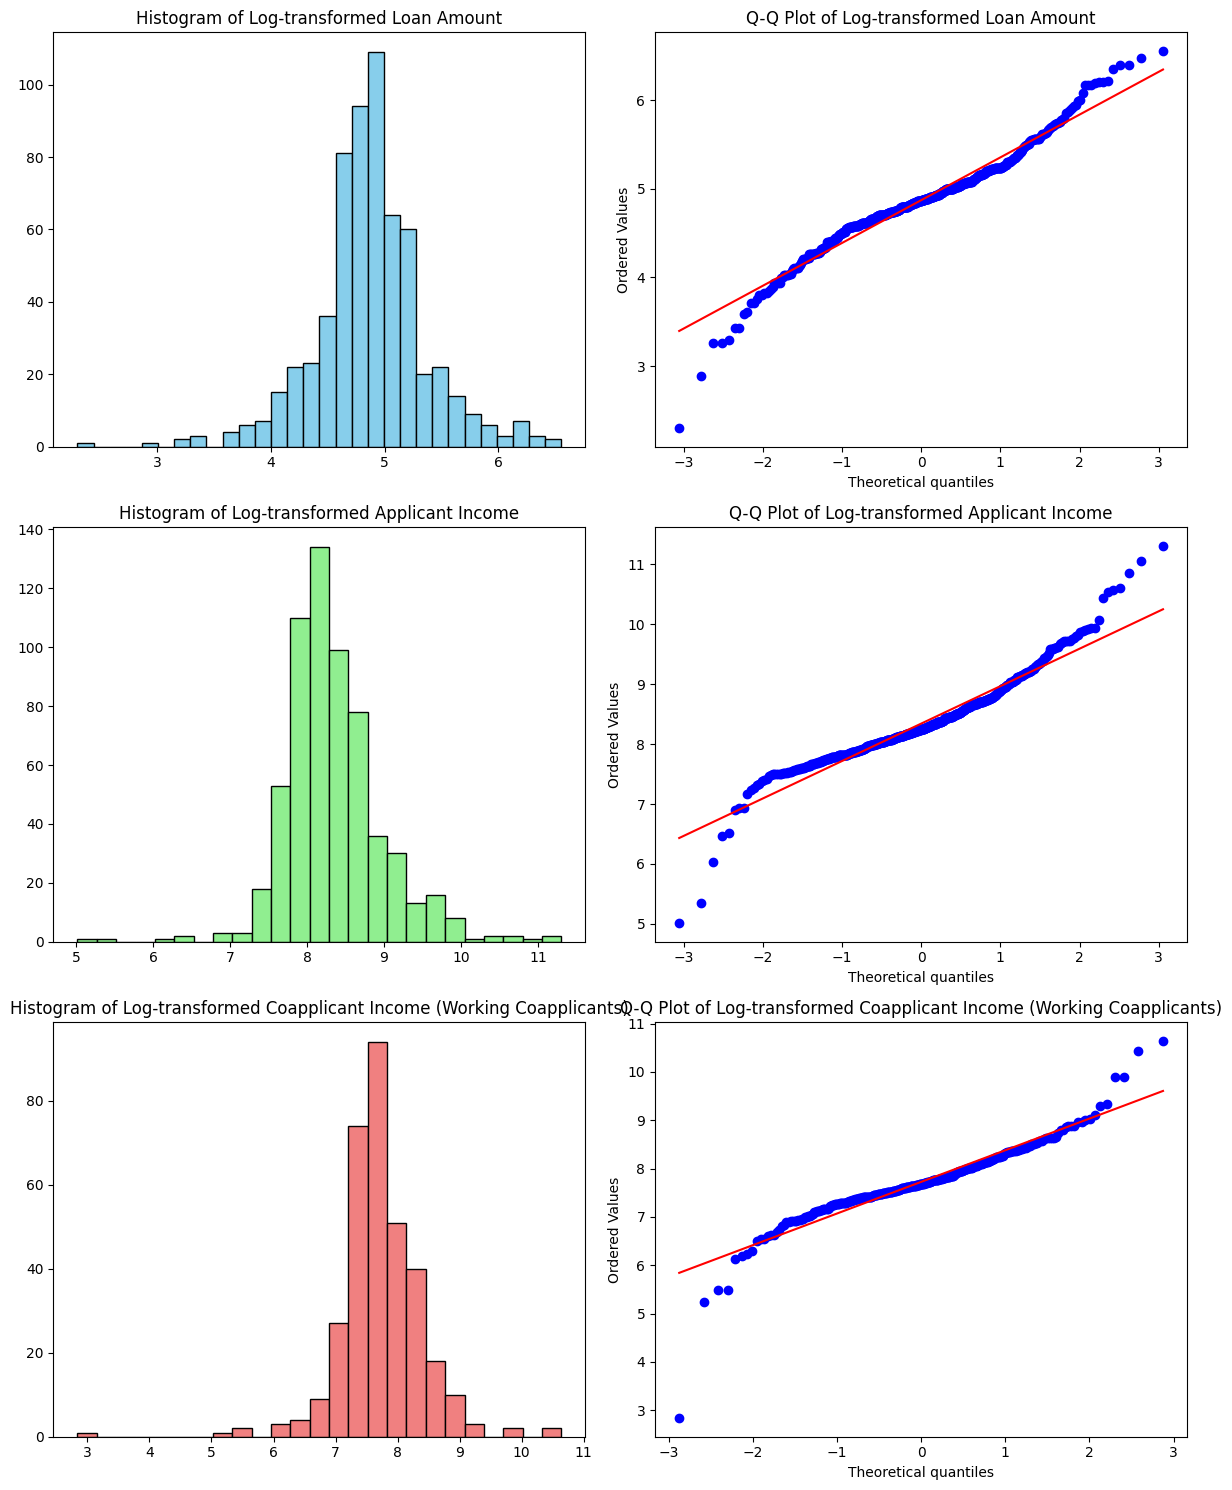

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Loan Amount Log-transformed
axs[0, 0].hist(df['Log_Loan_Amount_Log'], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title("Histogram of Log-transformed Loan Amount")

probplot(df['Log_Loan_Amount_Log'], dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Q-Q Plot of Log-transformed Loan Amount")

# Applicant Income Log-transformed
axs[1, 0].hist(df['Log_Applicant_Income'], bins=25, color='lightgreen', edgecolor='black')
axs[1, 0].set_title("Histogram of Log-transformed Applicant Income")

probplot(df['Log_Applicant_Income'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot of Log-transformed Applicant Income")

# Filter the DataFrame for working coapplicants"
df_working_coapplicants = df[df['Coapplicant_Working'] == 1] 

axs[2, 0].hist(df_working_coapplicants['Log_Coapplicant_Income'], bins=25, color='lightcoral', edgecolor='black')
axs[2, 0].set_title("Histogram of Log-transformed Coapplicant Income (Working Coapplicants)")

probplot(df_working_coapplicants['Log_Coapplicant_Income'], dist="norm", plot=axs[2, 1])
axs[2, 1].set_title("Q-Q Plot of Log-transformed Coapplicant Income (Working Coapplicants)")


plt.tight_layout()
plt.show()

<h3>
Explore the covariance and correlation matrix
<h/3>

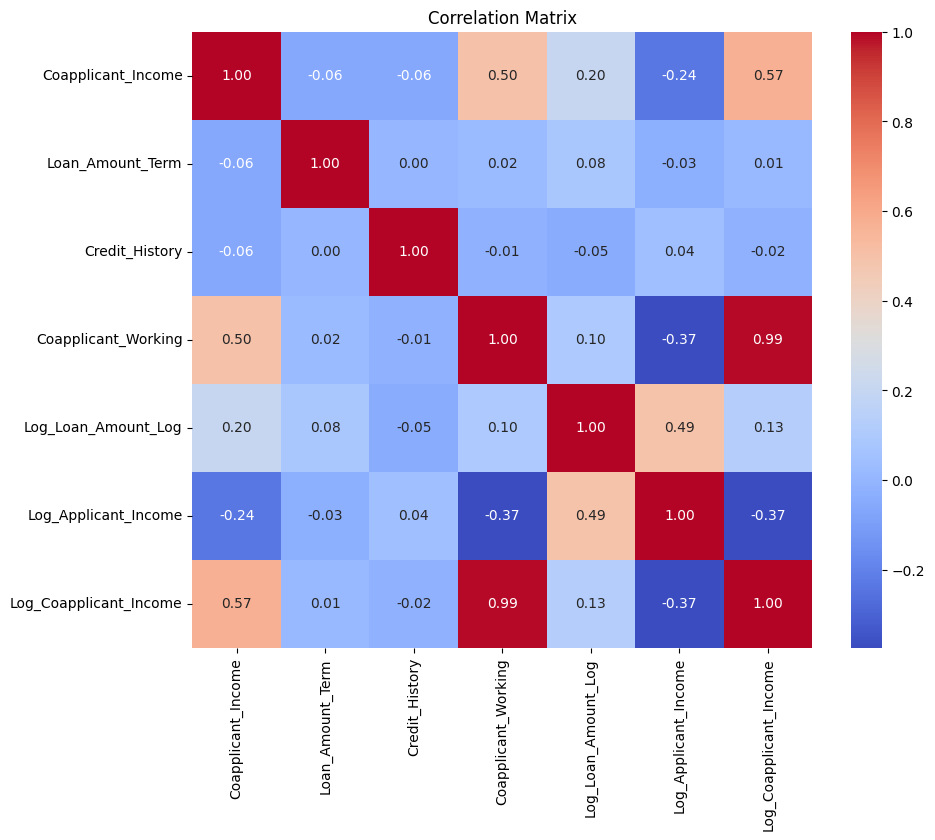

In [18]:
# Calculate the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(columns=['Loan_Amount', 'Applicant_Income'])

correlation_matrix = numeric_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [20]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Coapplicant_Working,Log_Loan_Amount_Log,Log_Applicant_Income,Log_Coapplicant_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,False,False,True,0,4.993232,8.674197,0.000000
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,False,False,True,1,4.859812,8.430327,7.319202
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,False,False,True,0,4.204693,8.006701,0.000000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,False,False,True,1,4.795791,7.857094,7.765993
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,False,False,True,0,4.955827,8.699681,0.000000


<h3>
One-hot encoding of categroical features
<h/3>

In [19]:
binary_vars = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Loan_Status', 'Coapplicant_Working']
df_encoded = pd.get_dummies(df, columns=binary_vars, drop_first=True)


multi_class_vars = ['Property_Area', 'Dependents']
df_encoded = pd.get_dummies(df_encoded, columns=multi_class_vars, drop_first=True)

df_encoded.head()

,Loan_ID,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,LoanTerm_Medium,LoanTerm_Short,LoanTerm_Standard,Log_Loan_Amount_Log,Log_Applicant_Income,...,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Loan_Status_Y,Coapplicant_Working_1,Property_Area_Semiurban,Property_Area_Urban,Dependents_1,Dependents_2,Dependents_3+
0,LP001002,5849,0.0,146.412162,360.0,False,False,True,4.993232,8.674197,...,False,False,True,True,False,False,True,False,False,False
1,LP001003,4583,1508.0,128.000000,360.0,False,False,True,4.859812,8.430327,...,False,False,True,False,True,False,False,True,False,False
2,LP001005,3000,0.0,66.000000,360.0,False,False,True,4.204693,8.006701,...,False,True,True,True,False,False,True,False,False,False
3,LP001006,2583,2358.0,120.000000,360.0,False,False,True,4.795791,7.857094,...,True,False,True,True,True,False,True,False,False,False
4,LP001008,6000,0.0,141.000000,360.0,False,False,True,4.955827,8.699681,...,False,False,True,True,False,False,True,False,False,False
